In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set_theme()

In [4]:
logins = pd.read_json('logins.json',dtype=True)
logins.head(3)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37


In [5]:
logins.dtypes

login_time    datetime64[ns]
dtype: object

In [70]:
login_counts_15_mins = logins.reset_index().set_index('login_time').resample('15T').count()
login_counts_15_mins.rename(columns={'index':'log_count'}, inplace=True)
login_counts_15_mins.head(3)

,log_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9


<AxesSubplot:ylabel='Count'>

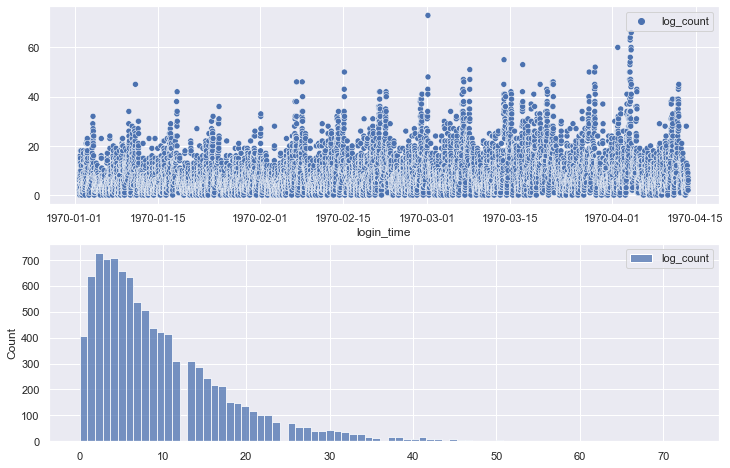

In [71]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
sns.scatterplot(data=login_counts_15_mins, ax=ax1)
sns.histplot(data=login_counts_15_mins)

In [72]:
# There are few outliers in the data 

Text(0.5, 1.0, 'login counts per 15 min with Saturdays highleighted')

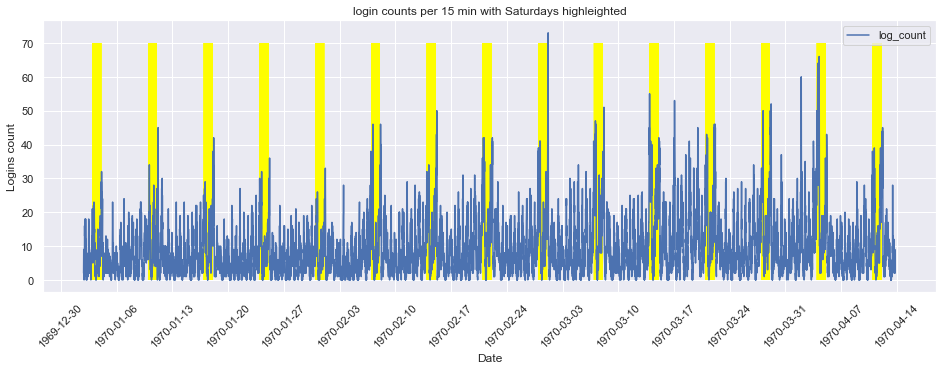

In [73]:
fig, ax = plt.subplots(figsize=(16,5))
sns.lineplot(data=login_counts_15_mins, ax=ax)

ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday = 1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)

ax.vlines(x=login_counts_15_mins[login_counts_15_mins.index.day_name().isin(['Saturday'])].index, ymin=0, ymax=70, color='yellow', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Logins count')
ax.set_title('login counts per 15 min with Saturdays highleighted')

We can see from the graph that this data set has weekly seasonality. Login counts per 15 minutes is maximum over the weekends (Saturdays and Sundays) and is the least in the middel of week.

In [74]:
def plot_data_for_time_period(start, end, daily=False, hourly=False):
    a_week_of_data = login_counts_15_mins[(login_counts_15_mins.index>start) & (login_counts_15_mins.index<end)]
    fig, ax = plt.subplots(figsize=(16,4))
    sns.lineplot(data=a_week_of_data)
    if daily:
        ax.xaxis.set_major_locator(dates.DayLocator())
        ax.xaxis.set_major_formatter(dates.DateFormatter('%a'))
        ax.set_title(f'weekly data from {start} to {end}')
        ax.set_xlabel('weekday')
        ax.set_ylabel('logins count')
        plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)
    if hourly:
        ax.xaxis.set_major_locator(dates.HourLocator())
        ax.xaxis.set_major_formatter(dates.DateFormatter('%H'))
        ax.set_title(f'hourly data from {start} to {end}')
        ax.set_xlabel('hour')
        ax.set_ylabel('logins count')
        plt.vlines(x= a_week_of_data[a_week_of_data.index.hour.isin([11,23])].index, ymin=0, ymax=60, color='yellow')
        plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
        

### Plotting hourly and daily data

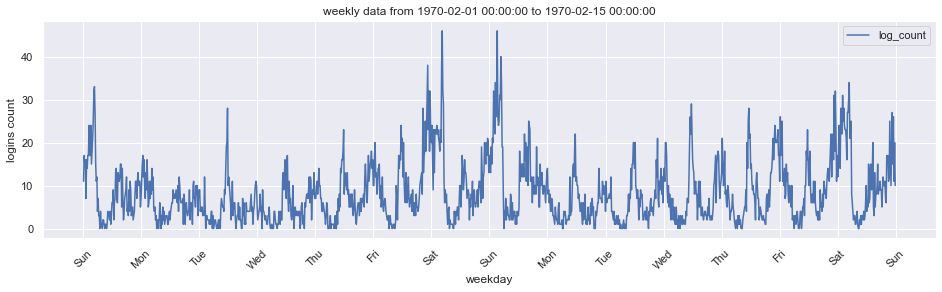

In [75]:
plot_data_for_time_period('1970-02-01 00:00:00', '1970-02-15 00:00:00', daily=True)

We also can see that we have daily seasonality as well. The number of logins peaks 2 times per day. Once at noon and once close to midnight.

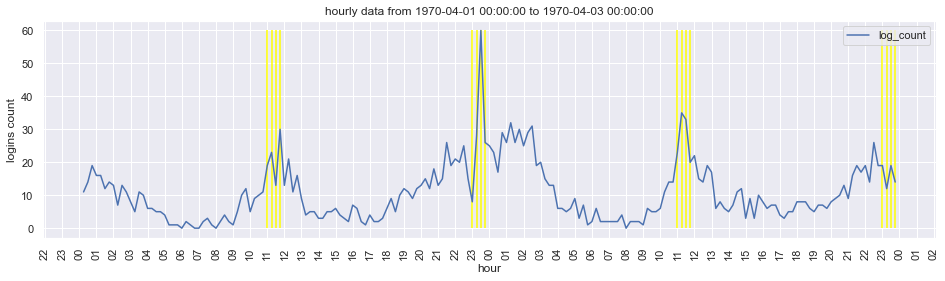

In [76]:
plot_data_for_time_period('1970-04-01 00:00:00', '1970-04-03 00:00:00', hourly=True)


(-0.1, 0.4)

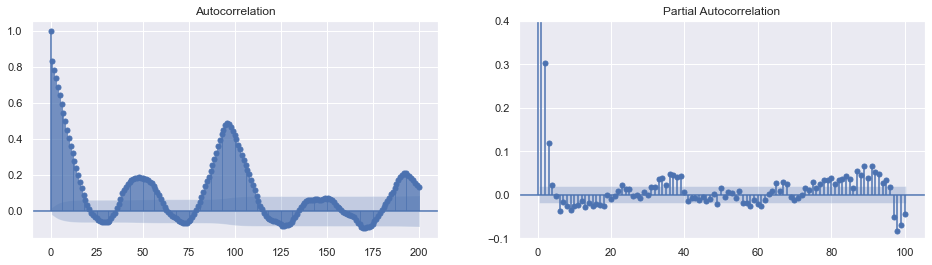

In [77]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
_=plot_acf(login_counts_15_mins, lags=200, ax=ax1)
_=plot_pacf(login_counts_15_mins, lags=100, ax=ax2)
ax2.set_ylim([-0.1,0.4])

The ACF plots above confirm that the there is a large peak at midnight and smaller peak at noon.

In [78]:
login_counts_15_mins['weekday'] = login_counts_15_mins.index.day_name()
sorted_df = login_counts_15_mins.sort_values(by='log_count', ascending=False)[:50]
sorted_df.style.apply(lambda x: ['' if x.weekday in ['Sunday', 'Saturday'] else 'background: yellow' for i in x], axis=1)

,log_count,weekday
login_time,,
1970-03-01 04:30:00,73,Sunday
1970-04-04 05:30:00,66,Saturday
1970-04-04 01:30:00,64,Saturday
1970-04-04 01:15:00,63,Saturday
1970-04-01 23:30:00,60,Wednesday
1970-04-04 05:00:00,60,Saturday
1970-04-04 04:45:00,59,Saturday
1970-04-04 05:15:00,59,Saturday
1970-04-04 01:45:00,56,Saturday


### EDA results: 
    - Demand was the highiest over the weekend.
    - There was a higher demand around noon and midnight during each day.
    - In some weekdays the demand was unusually high 
    - The distribution is right skewed and there are a few outliers in the data 

# Part 2 ‐ Experiment and metrics design

### Method 1: Student’s t-test:

 - randomly select a group of drivers and assign them to the test group (reimburse the toll cost to this group).
 - randomly select another group of drivers and assign them to the control group (don't reimburse the toll cost to this group).
 - metric : number of rides per day for each driver.
 - significance level (alpha) = 0.05
 - track the number of rides per day for a month for both groups.
 - test whether the means of two independent samples are significantly different using independent samples t-test.
     - if p value < 0.05 reimursing the toll cost probably had an effect on number of rides
     - if p value > 0.05 reimursing the toll cost probably did not have an effect on number of rides
 

### Method 2: Paired t_test:
- metric: number of rides per day for each driver.
- significance level (alpha) = 0.05
- Reimburse the toll cost to all drivers for a month and track the number of trips per day.
- perform paired t-test to see if the means of two paired samples are significantly different.
     - if p value < 0.05 reimursing the toll cost probably had an effect on number of rides
     - if p value > 0.05 reimursing the toll cost probably did not have an effect on number of rides
 


# Part 3 ‐ Predictive modeling
### What factors are the best predictors for retention?

In [79]:
ultimate_data = pd.read_json('ultimate_data_challenge.json')
ultimate_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [80]:
ultimate_data.isna().any()

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver       True
avg_surge                 False
last_trip_date            False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
dtype: bool

In [81]:
ultimate_data.signup_date = pd.to_datetime(ultimate_data.signup_date)
ultimate_data.last_trip_date = pd.to_datetime(ultimate_data.last_trip_date)

In [82]:
#finding each user's end of 6 month period. we consider 6 month is 181 days
ultimate_data['six_month_period'] = ultimate_data.signup_date + pd.to_timedelta(181, unit='days')

In [83]:
#finding each user's days between last ride and the end of 6 moth after registeration
ultimate_data['days_since_last_ride'] = (ultimate_data.six_month_period - ultimate_data.last_trip_date).astype('timedelta64[24h]')
# ultimate_data.loc[ultimate_data['days_since_last_ride']<0]=0

In [84]:
ultimate_data.describe().round(2)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,days_since_last_ride
count,50000.00,41878.00,50000.00,50000.00,50000.00,50000.00,49799.00,50000.00
mean,2.28,4.60,1.07,8.85,60.93,5.80,4.78,88.21
std,3.79,0.62,0.22,19.96,37.08,5.71,0.45,62.13
min,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00
25%,0.00,4.30,1.00,0.00,33.30,2.42,4.70,31.00
50%,1.00,4.90,1.00,0.00,66.70,3.88,5.00,71.00
75%,3.00,5.00,1.05,8.60,100.00,6.94,5.00,154.00
max,125.00,5.00,8.00,100.00,100.00,160.96,5.00,181.00


The median of the number of trips in first 30 days is 1. Meaning half of the new customers only use the service once in the first month. The max value is 125 rides per month which seems unusually high for a rider.

the rider’s average rating of their drivers over all of their trips has minimum of 1 and maximum of 5. Only 25% of the ratings is below 4.3.

In [85]:
#removing the outlier from the dataset
ultimate_data.sort_values(by='trips_in_first_30_days', ascending=False)
ultimate_data = ultimate_data.loc[ultimate_data.trips_in_first_30_days !=125]

In [86]:
#What fraction of the observed users were retained?

frac_retained = round(100*ultimate_data[ultimate_data.days_since_last_ride<=30].shape[0]/ ultimate_data.shape[0],2)
print(f'{frac_retained}% of observed users were retained')

24.39% of observed users were retained


In [87]:
ultimate_data['active'] = 0
ultimate_data.loc[ultimate_data.days_since_last_ride<=30, 'active']=1

<AxesSubplot:xlabel='city', ylabel='count'>

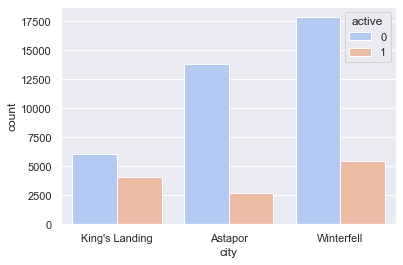

In [88]:
# city has an important effect on retaintion rate. More people from King's landing retained compare to winterfell
sns.countplot(x='city', hue='active', data=ultimate_data, palette='coolwarm')

<AxesSubplot:xlabel='phone', ylabel='count'>

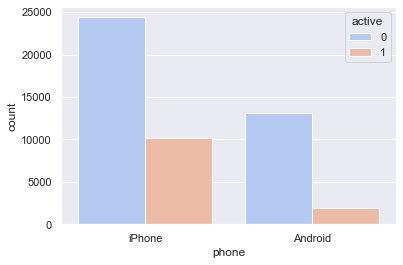

In [89]:
#iPhone users seems to have a higher retain rate compare to android users maybe the android user interface is not as friendly
sns.countplot(x='phone', hue='active', data=ultimate_data, palette='coolwarm')

<AxesSubplot:>

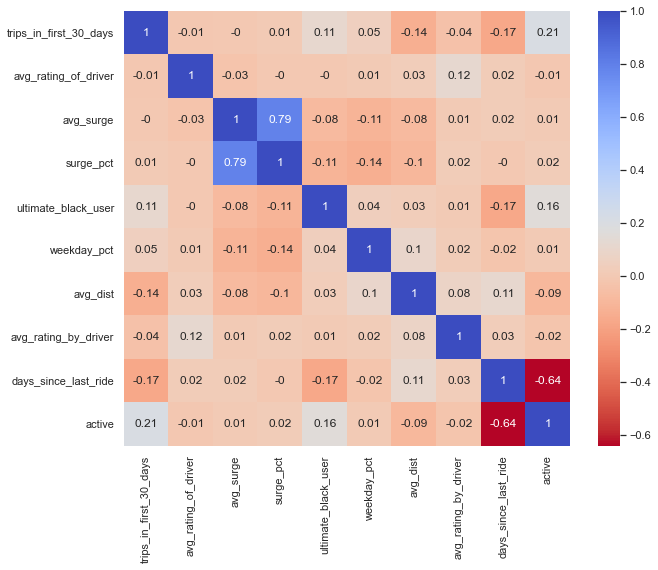

In [90]:
plt.figure(figsize=(10,8))
sns.heatmap(ultimate_data.corr().round(2), cmap='coolwarm_r', annot=True)

The is a strong collinearity between surge percent and average surge. Also we can see that the number of trips in the fisrt 30 days and being an ultimate black user a positive correlation with the user retention.

In [91]:
ultimate_data

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,six_month_period,days_since_last_ride,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-07-25,38.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-07-29,85.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-07-06,180.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-07-10,11.0,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-07-27,134.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,2014-07-25,50.0,0
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,2014-07-24,180.0,0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,2014-07-31,70.0,0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,2014-07-14,180.0,0


It appears from the log graph that riders with a langer average distance have a lower retain rate.

In [92]:
def log_feature_vs_active(feature, ax):
    sns.boxplot(x=ultimate_data['active'], y =np.log(ultimate_data[feature]+1),palette='coolwarm', ax=ax)
def linear_feature_vs_active(feature, ax):
    sns.boxplot(x=ultimate_data['active'], y =ultimate_data[feature],palette='coolwarm', ax=ax)

<AxesSubplot:xlabel='ultimate_black_user', ylabel='count'>

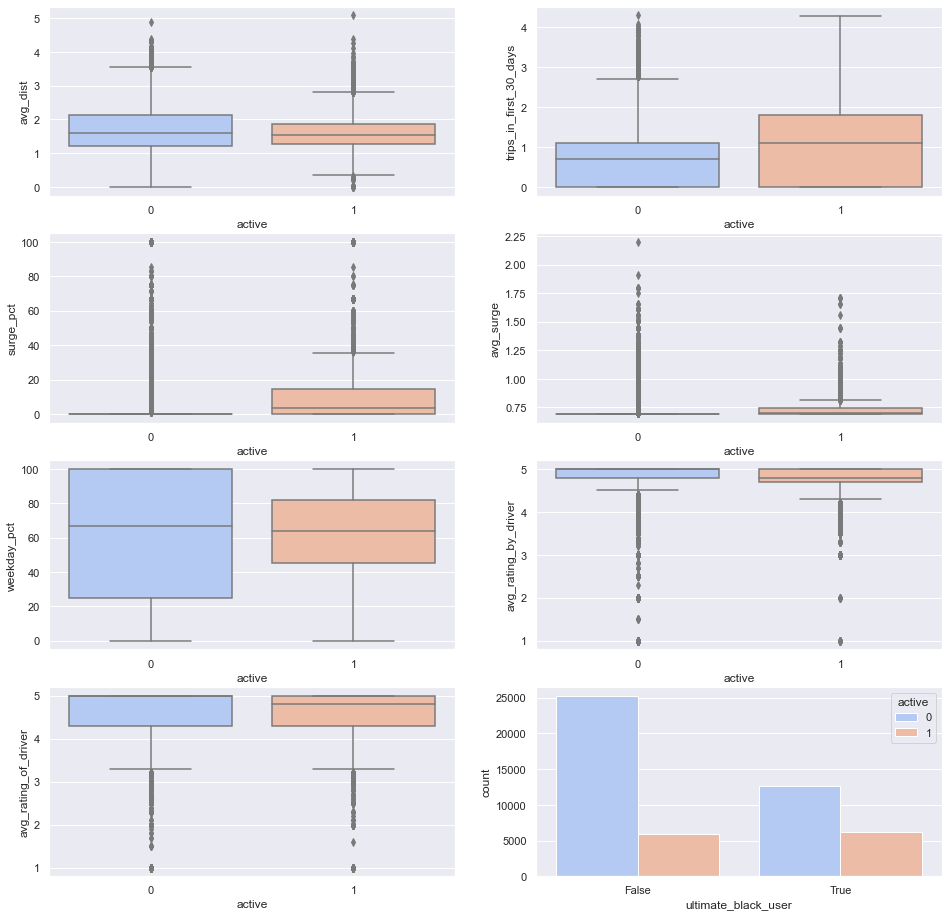

In [93]:
#plotting target vs various features
fig, ax = plt.subplots(4,2,figsize=(16,16))
log_feature_vs_active('avg_dist', ax=ax[0,0])
log_feature_vs_active('trips_in_first_30_days', ax=ax[0,1])
linear_feature_vs_active('surge_pct', ax=ax[1,0])
log_feature_vs_active('avg_surge', ax=ax[1,1])
linear_feature_vs_active('weekday_pct', ax=ax[2,0])
linear_feature_vs_active('avg_rating_by_driver', ax=ax[2,1])
linear_feature_vs_active('avg_rating_of_driver', ax=ax[3,0])
sns.countplot(data=ultimate_data, x='ultimate_black_user', hue='active', palette='coolwarm',ax=ax[3,1])

In [94]:
print(ultimate_data.loc[ultimate_data.active==0,'trips_in_first_30_days'].median())
print(ultimate_data.loc[ultimate_data.active==1,'trips_in_first_30_days'].median())

1.0
2.0


In [95]:
ultimate_data.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
six_month_period             0
days_since_last_ride         0
active                       0
dtype: int64

In [96]:
ultimate_data[ultimate_data.phone.isna()]['active'].value_counts()

0    312
1     84
Name: active, dtype: int64

In [97]:
ultimate_data[ultimate_data.phone.isna()]['city'].value_counts()

Winterfell        211
Astapor           121
King's Landing     64
Name: city, dtype: int64

In [98]:
ultimate_data.avg_rating_of_driver.fillna(ultimate_data.avg_rating_of_driver.median(),inplace=True)
ultimate_data.avg_rating_by_driver.fillna(ultimate_data.avg_rating_by_driver.median(),inplace=True)
ultimate_data.dropna(inplace=True)

In [99]:
# ultimate_data['ultimate_black_user'] = ultimate_data['ultimate_black_user'].astype('int')

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [101]:
# defining X and y and oversampling the minortity calls
ultimate_data = ultimate_data.drop(['last_trip_date', 'signup_date', 'days_since_last_ride','six_month_period'], axis=1)
X = ultimate_data.drop(['active'], axis=1)
y =ultimate_data.active

oversampling = RandomOverSampler(sampling_strategy='minority')
X, y =oversampling.fit_resample(X, y)

<AxesSubplot:>

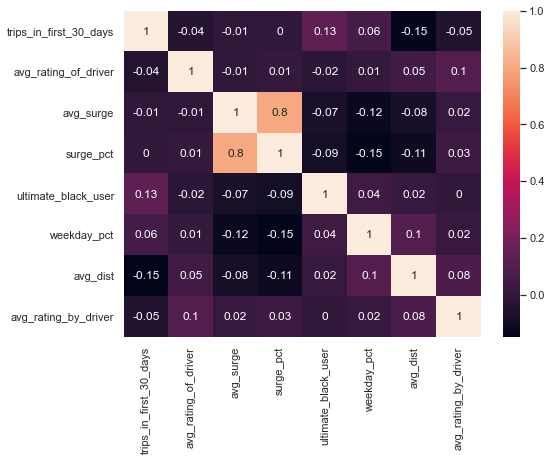

In [102]:
plt.figure(figsize=(8,6))
sns.heatmap(X.corr().round(2), annot=True)

In [103]:
#test and train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [104]:
#trying vanilla models 
numeric_columns = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 
                   'ultimate_black_user', 'weekday_pct', 'avg_dist','avg_rating_by_driver']
cat_columns = ['city', 'phone']

def vanilla_models(model):
    transformer = ColumnTransformer([('ohe', OneHotEncoder(sparse=False), cat_columns), 
                       ('scale', StandardScaler(), numeric_columns)])
    pipe = Pipeline([('transformer', transformer), (f'{model}', model())])
    scoring =['accuracy', 'precision', 'recall', 'f1']
    pipe_cv = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring)
    return pipe_cv

In [79]:
def vanilla_models_results(models):
    vanilla_results = pd.DataFrame()
    for model in models:
        results = vanilla_models(model)
        for key, value in results.items():
            results[key]= value.mean()
        vanilla_results=pd.concat([vanilla_results, pd.DataFrame(results, columns=results.keys(), index=[model.__name__]) ])
    return vanilla_results
models =[LogisticRegression, RandomForestClassifier, KNeighborsClassifier, GaussianNB, XGBClassifier]
vanilla_models_results(models)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
LogisticRegression,0.123070,0.022073,0.675864,0.681383,0.660810,0.670916
RandomForestClassifier,3.266256,0.229469,0.863964,0.814754,0.942151,0.873831
KNeighborsClassifier,0.533460,0.731122,0.750917,0.721827,0.816518,0.766250
GaussianNB,0.080049,0.021521,0.673830,0.647939,0.761703,0.700203
XGBClassifier,1.375344,0.032917,0.780258,0.768221,0.802714,0.785083


Because we're looking for user retention, we want to maximize recall. We choose RF and XGBoost here.

In [105]:
# finding the important features 
def find_important_feats():
    transformer = ColumnTransformer([('ohe', OneHotEncoder(sparse=False), cat_columns), 
                   ('scale', StandardScaler(), numeric_columns)],remainder='passthrough')
    results = []
    for i in range(1,9):
        rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=i)
        pipe_rfe=Pipeline([('transform', transformer), ('rfe', rfe)])
        rfe_cv = cross_validate(pipe_rfe, X_train, y_train, cv=3, scoring='recall')
        results.append((i, rfe_cv['test_score'].mean()))
    return results 
            
find_important_feats()


[(1, 0.7118899355877311),
 (2, 0.756801642079608),
 (3, 0.813616712872767),
 (4, 0.8423245650763976),
 (5, 0.8833686613285446),
 (6, 0.9045412630257038),
 (7, 0.9033074895463238),
 (8, 0.9125100836245407)]

The results show that using almost all the features provides the best model performance so we will keep them all. However, depend on what is the cost of collecting these features, if the recall score of 90% is acceptable by  Ultimate we can only use 6 features to reduce the cost of data collection and storage.

In [114]:
rfe = RFE(estimator=XGBClassifier(), n_features_to_select=9)
pipe_rfe=Pipeline([('transform', transformer), ('rfe', rfe)])
pipe_rfe.fit(X_train,y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(sparse=False),
                                                  ['city', 'phone']),
                                                 ('scale', StandardScaler(),
                                                  ['trips_in_first_30_days',
                                                   'avg_rating_of_driver',
                                                   'avg_surge', 'surge_pct',
                                                   'ultimate_black_user',
                                                   'weekday_pct', 'avg_dist',
                                                   'avg_rating_by_driver'])])),
                ('rfe',
                 RFE(estimator=XGBClassifier(bas...
                                             interaction_constraints=None,
               

In [115]:
rf_feature_names = list(rf_grid.best_estimator_.named_steps.transform.named_transformers_.ohe.get_feature_names())+numeric_columns
feature_importance_results = pd.DataFrame()
feature_importance_results['features'] = np.array(rf_feature_names)
feature_importance_results['ranking'] = pipe_rfe.named_steps.rfe.ranking_
feature_importance_results.sort_values(by='ranking')

,features,ranking
0,x0_Astapor,1
1,x0_King's Landing,1
3,x1_Android,1
5,trips_in_first_30_days,1
7,avg_surge,1
8,surge_pct,1
9,ultimate_black_user,1
10,weekday_pct,1
12,avg_rating_by_driver,1
6,avg_rating_of_driver,2


# RF MODEL 

In [93]:
transformer = ColumnTransformer([('ohe', OneHotEncoder(sparse=False), cat_columns), 
                   ('scale', StandardScaler(), numeric_columns)],remainder='passthrough')
rf_cl = RandomForestClassifier()
pipe = Pipeline([('transform', transformer), ('rf_cl', rf_cl)])
rf_param_grid = {'rf_cl__n_estimators':[30,50,80,100,120], 'rf_cl__max_depth':[5,10,25,20,30],'rf_cl__class_weight':["balanced_subsample", 'balanced'],'rf_cl__max_features':np.arange(1,13,2)}
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
rf_grid = RandomizedSearchCV(pipe, param_distributions=rf_param_grid , cv=cv, scoring='recall', n_iter=50)
rf_grid.fit(X_train,y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1),
                   estimator=Pipeline(steps=[('transform',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(sparse=False),
                                                                               ['city',
                                                                                'phone']),
                                                                              ('scale',
                                                                               StandardScaler(),
                                                                               ['trips_in_first_30_days',
                                                                                'avg_rating_of_drive

In [102]:
print(f'train recall score:{rf_grid.score(X_train,y_train)}')
print(f'test recall score:{rf_grid.score(X_test,y_test)}')


train recall score:0.9989330488130168
test recall score:0.9606561749799947


In [94]:
rf_grid.best_params_

{'rf_cl__n_estimators': 100,
 'rf_cl__max_features': 5,
 'rf_cl__max_depth': 25,
 'rf_cl__class_weight': 'balanced'}

In [95]:
rf_feature_names = list(rf_grid.best_estimator_.named_steps.transform.named_transformers_.ohe.get_feature_names())+numeric_columns
pd.DataFrame(rf_grid.best_estimator_.named_steps.rf_cl.feature_importances_, index=rf_feature_names).sort_values(by=0, ascending=False)

,0
avg_dist,0.306862
weekday_pct,0.133148
avg_rating_by_driver,0.116991
surge_pct,0.099942
avg_rating_of_driver,0.083463
trips_in_first_30_days,0.079419
avg_surge,0.069516
x0_King's Landing,0.036797
ultimate_black_user,0.021208
x1_iPhone,0.015397


In [96]:
#check to see if the model is not overfitting and will generalize well
rf_results = pd.DataFrame(rf_grid.cv_results_)
rf_results = rf_results[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
rf_results.head()

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
8,"{'rf_cl__n_estimators': 100, 'rf_cl__max_featu...",1,0.922463,0.003005,0.925078,0.924685,0.924377,0.916375,0.922985
28,"{'rf_cl__n_estimators': 120, 'rf_cl__max_featu...",2,0.922396,0.002739,0.924177,0.925485,0.923077,0.916775,0.922084
33,"{'rf_cl__n_estimators': 80, 'rf_cl__max_featur...",3,0.922012,0.002934,0.925878,0.924785,0.921977,0.917875,0.922885
22,"{'rf_cl__n_estimators': 120, 'rf_cl__max_featu...",4,0.922012,0.003732,0.922977,0.925885,0.923577,0.914074,0.923485
14,"{'rf_cl__n_estimators': 100, 'rf_cl__max_featu...",5,0.921712,0.003731,0.923377,0.926285,0.922877,0.914274,0.922985


In [37]:
pred= rf_grid.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[6067 1431]
 [ 317 7181]]
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      7498
           1       0.83      0.96      0.89      7498

    accuracy                           0.88     14996
   macro avg       0.89      0.88      0.88     14996
weighted avg       0.89      0.88      0.88     14996



### The model recall for class 1 is 96%. Meaning the model can identify 96% of the users that will be retained early on. The model also has precision of 83% for class 1. The overall accuracy of the model is 88%.

# XGBOOST MODEL 

In [108]:
xgb_pipe = Pipeline([('transform', transformer),
                     ('xgb_cl', XGBClassifier())])

xgb_param_distributions = {'xgb_cl__max_depth': np.arange(2,15,2), 
                           'xgb_cl__learning_rate':[0.001, 0.005, 0.01,0.05,0.1,0.5,1.0],
                           'xgb_cl__colsample_bytree':np.arange(0.5,0.9,0.1)
                          }
xgb_grid = RandomizedSearchCV(xgb_pipe, param_distributions=xgb_param_distributions, n_iter=20, scoring='recall')
xgb_grid.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('transform',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(sparse=False),
                                                                               ['city',
                                                                                'phone']),
                                                                              ('scale',
                                                                               StandardScaler(),
                                                                               ['trips_in_first_30_days',
                                                                                'avg_rating_of_driver',
                                                                                'avg

In [109]:
xgb_grid.best_params_

{'xgb_cl__max_depth': 14,
 'xgb_cl__learning_rate': 0.5,
 'xgb_cl__colsample_bytree': 0.7999999999999999}

In [110]:
xgb_results = pd.DataFrame(xgb_grid.cv_results_)
xgb_results = xgb_results[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
xgb_results.head()

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
16,"{'xgb_cl__max_depth': 14, 'xgb_cl__learning_ra...",1,0.925814,0.002155,0.927476,0.925809,0.921654,0.927155,0.926976
12,"{'xgb_cl__max_depth': 12, 'xgb_cl__learning_ra...",2,0.907709,0.002862,0.909470,0.908136,0.902150,0.908651,0.910137
3,"{'xgb_cl__max_depth': 8, 'xgb_cl__learning_rat...",3,0.850293,0.002530,0.851450,0.849283,0.854476,0.849308,0.846949
17,"{'xgb_cl__max_depth': 14, 'xgb_cl__learning_ra...",4,0.823653,0.002864,0.826442,0.819106,0.822470,0.826971,0.823274
9,"{'xgb_cl__max_depth': 8, 'xgb_cl__learning_rat...",5,0.812483,0.002791,0.813271,0.810604,0.817636,0.810468,0.810437


In [113]:
xgb_feature_importance = pd.DataFrame(xgb_grid.best_estimator_.named_steps.xgb_cl.feature_importances_, index=rf_feature_names).sort_values(by=0, ascending=False)
xgb_feature_importance

,0
x0_King's Landing,0.179483
surge_pct,0.132934
x1_iPhone,0.118047
x1_Android,0.106140
avg_rating_by_driver,0.074125
weekday_pct,0.067868
avg_dist,0.054048
x0_Astapor,0.051406
ultimate_black_user,0.050479
trips_in_first_30_days,0.048543


In [112]:
xgb_pred = xgb_grid.predict(X_test)
print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test,xgb_pred))

[[6189 1309]
 [ 478 7020]]
              precision    recall  f1-score   support

           0       0.93      0.83      0.87      7498
           1       0.84      0.94      0.89      7498

    accuracy                           0.88     14996
   macro avg       0.89      0.88      0.88     14996
weighted avg       0.89      0.88      0.88     14996



The recall value for the xgb model is 94%. The random forest model had a slightly better performance so we will choose that as the final model. The results show which features are more important in user retention and Ultimate can monitor these features to prevent user churn.